# LEAST SQUARED GAN

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import FloatTensor
import torchvision
from torchvision import datasets
from torchvision import transforms
import torchvision.utils as vutils
from torch.utils import data
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import os
import sys
import time
import argparse
import datetime
import numpy as np
import random
from google.colab import drive
from pathlib import Path

# PARAMS

In [0]:
batch_size = 64 
dataset_name = 'MNIST'  # Possible datasets [MNIST, FASHION, CELEBA, CIFAR10]
img_size = (64,64,1)
lr = 2e-4
betas = (.5, .99)
epochs = 25
ngpu = 1
weights_backup = True #Save weights during training
weights_restore = True #Set to False if want to restart training from zero

nz = 100 #size of latent z vector
ngf = 64 #number of generator filters
ndf = 64 #number of discriminator filters
outf = './out'

In [0]:
mean = {'CIFAR10': (0.4914, 0.4822, 0.4465), 'MNIST': (0.5)}
std = {'CIFAR10': (0.2023, 0.1994, 0.2010), 'MNIST': (0.5)}

In [18]:
if weights_backup: 
  drive.mount('/content/drive')
  path = '/content/drive/My Drive/TESI/TESI GAN/Maffione/Colab/DCGAN basic/Least Squared/'
  image_path = path + 'images/' + dataset_name 
  checkpoint_file = path + 'weights/' + dataset_name + '_lsgan.pt'
  checkpoint_file_half = path + 'weights/' + dataset_name + '-' + str(int(epochs/2)) + '_lsgan.pt'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# DATALOADER

Dataset MNIST contains 60000 images


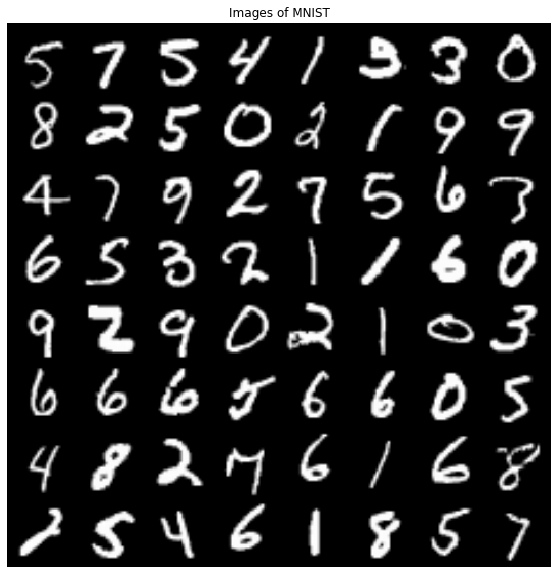

In [19]:
transform=transforms.Compose([
                               transforms.Resize(img_size[0]),
                               transforms.ToTensor(),
                               transforms.Normalize([mean[dataset_name]], [std[dataset_name]])
                               ])

if dataset_name == 'CIFAR10':
  dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
elif dataset_name == 'LSUN':
  dataset = datasets.LSUN(root='./data',classes=['bedroom_train'], transform=transforms)
elif dataset_name== 'CELEBA':
  dataset = datasets.CelebA(root='./data', download=True, transform=transform)
elif  dataset_name== 'MNIST':
  dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
elif  dataset_name== 'FASHION':
  dataset = datasets.FashionMNIST(root='./data', download=True, transform=transform)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2,pin_memory=True)
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some images
real_batch = next(iter(dataloader))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Images of {}".format(dataset_name))
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

print('Dataset {} contains {} images'.format(dataset_name, len(dataset)))

# GENERATOR

In [0]:
class Generator(nn.Module):
    def __init__(self, nz, ngf, nChannels):
        super(Generator, self).__init__()

        self.layer1 = nn.Sequential(
            # input : z
            # Generator will be consisted with a series of deconvolution networks

            # Input size : input latent vector 'z' with dimension (nz)*1*1
            # Output size: output feature vector with (ngf*8)*4*4
            nn.ConvTranspose2d(
                in_channels = nz,
                out_channels = ngf*8,
                kernel_size = 4,
                stride = 1,
                padding = 0,
                bias = False
            ),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True)
        )

        self.layer2 = nn.Sequential(
            # Input size : input feature vector with (ngf*8)*4*4
            # Output size: output feature vector with (ngf*4)*8*8
            nn.ConvTranspose2d(
                in_channels = ngf*8,
                out_channels = ngf*4,
                kernel_size = 4,
                stride = 2,
                padding = 1,
                bias = False
            ),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True)
        )

        self.layer3 = nn.Sequential(
            # Input size : input feature vector with (ngf*4)*8*8
            # Output size: output feature vector with (ngf*2)*16*16
            nn.ConvTranspose2d(
                in_channels = ngf*4,
                out_channels = ngf*2,
                kernel_size = 4,
                stride = 2,
                padding = 1,
                bias = False
            ),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True)
        )

        self.layer4 = nn.Sequential(
            # Input size : input feature vector with (ngf*2)*16*16
            # Output size: output feature vector with (ngf)*32*32
            nn.ConvTranspose2d(
                in_channels = ngf*2,
                out_channels = ngf,
                kernel_size = 4,
                stride = 2,
                padding = 1,
                bias = False
            ),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True)
        )

        self.layer5 = nn.Sequential(
            # Input size : input feature vector with (ngf)*32*32
            # Output size: output image with (nChannels)*(image width)*(image height)
            nn.ConvTranspose2d(
                in_channels = ngf,
                out_channels = nChannels,
                kernel_size =4,
                stride = 2,
                padding = 1,
                bias = False
            ),
            nn.Tanh() # To restrict each pixels of the fake image to 0~1
            # Yunjey seems to say that this does not matter much
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)

        return out

# DISCRIMINATOR 

In [0]:
class Discriminator(nn.Module):
    def __init__(self, ndf, nChannels):
        super(Discriminator, self).__init__()
        # input : (batch * nChannels * image width * image height)
        # Discriminator will be consisted with a series of convolution networks

        self.layer1 = nn.Sequential(
            # Input size : input image with dimension (nChannels)*64*64
            # Output size: output feature vector with (ndf)*32*32
            nn.Conv2d(
                in_channels = nChannels,
                out_channels = ndf,
                kernel_size = 4,
                stride = 2,
                padding = 1,
                bias = False
            ),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.layer2 = nn.Sequential(
            # Input size : input feature vector with (ndf)*32*32
            # Output size: output feature vector with (ndf*2)*16*16
            nn.Conv2d(
                in_channels = ndf,
                out_channels = ndf*2,
                kernel_size = 4,
                stride = 2,
                padding = 1,
                bias = False
            ),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.layer3 = nn.Sequential(
            # Input size : input feature vector with (ndf*2)*16*16
            # Output size: output feature vector with (ndf*4)*8*8
            nn.Conv2d(
                in_channels = ndf*2,
                out_channels = ndf*4,
                kernel_size = 4,
                stride = 2,
                padding = 1,
                bias = False
            ),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.layer4 = nn.Sequential(
            # Input size : input feature vector with (ndf*4)*8*8
            # Output size: output feature vector with (ndf*8)*4*4
            nn.Conv2d(
                in_channels = ndf*4,
                out_channels = ndf*8,
                kernel_size = 4,
                stride = 2,
                padding = 1,
                bias = False
            ),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.layer5 = nn.Sequential(
            # Input size : input feature vector with (ndf*8)*4*4
            # Output size: output probability of fake/real image
            nn.Conv2d(
                in_channels = ndf*8,
                out_channels = 1,
                kernel_size = 4,
                stride = 1,
                padding = 0,
                bias = False
            ),
            # nn.Sigmoid() -- Replaced with Least Square Loss
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)

        return out.view(-1,1)

# MAIN

Checkpoint not used or not exist
###########   TRAINING STARTED  ############
Epoch [ 0/25] Loss(D): 0.1275 Loss(G): 0.8524 


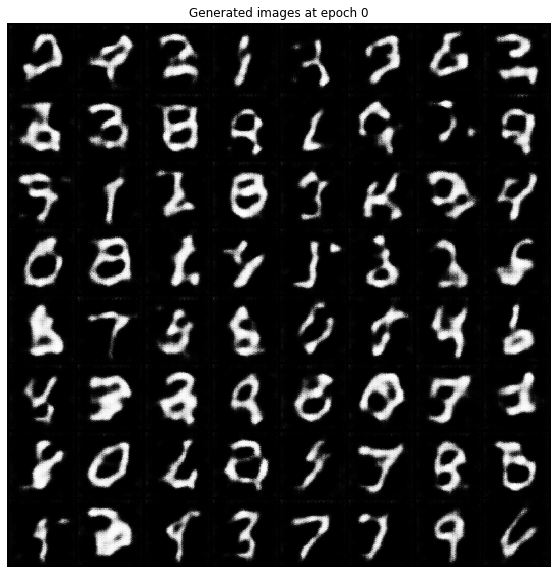

In [0]:
manualSeed = random.randint(1, 10000)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.cuda.manual_seed_all(manualSeed)

use_cuda = torch.cuda.is_available()
cudnn.benchmark = True
use_cuda = torch.cuda.is_available()

######################### Model Setup
if(dataset_name == 'CIFAR10'):
    nc = 3
elif(dataset_name == 'MNIST'):
    nc = 1
    
try:
    os.makedirs(outf)
except OSError:
    pass

netD = Discriminator(ndf, nc)
netG = Generator(nz, ngf, nc)

if(use_cuda):
    netD.cuda()
    netG.cuda()
    cudnn.benchmark = True

######################### Loss & Optimizer
criterion = nn.BCELoss()
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=betas)
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=betas)

######################### Global Variables
real_label, fake_label = 1, 0
start_epoch = 0
img_list = []
G_losses = []
D_losses = []

fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)

######################### Restore Checkpoint
if weights_restore and Path(checkpoint_file).exists():
    netG,netD,optimizerG,optimizerD,start_epoch = restore_checkpoint(checkpoint_file)
    print('Checkpoint found and restored at epoch {}'.format(start_epoch))
else: 
    print('Checkpoint not used or not exist' )


######################### Training Stage
print('###########   TRAINING STARTED  ############')
for epoch in range(epochs-start_epoch):
    start = time.time()
    epoch += start_epoch
    for i, (data, _) in enumerate(dataloader):
        ######################### fDx : Gradient of Discriminator
        netD.zero_grad()
        
        # train with real data
        real = data.to(device)
        b_size = real.size(0)
        label = torch.full((b_size,), real_label, device=device)
       
        output = netD(data.cuda()) # Forward propagation, this should result in '1'
        errD_real = 0.5 * torch.mean((output-label)**2) # criterion(output, label)
        errD_real.backward()

        # train with fake data
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        
        output = netD(fake.detach()) # Forward propagation for fake, this should result in '0'
        errD_fake = 0.5 * torch.mean((output-label)**2) # criterion(output, label)
        errD_fake.backward()
       
        errD = errD_fake + errD_real
        optimizerD.step()

        ######################### fGx : Gradient of Generator
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake) # Forward propagation of generated image, this should result in '1'
        errG = 0.5 * torch.mean((output - label)**2) # criterion(output, label)
        errG.backward()
        optimizerG.step()

        ######################### LOG

    print('Epoch [%2d/%2d] Loss(D): %.4f Loss(G): %.4f ' %(epoch, epochs, errD.item(), errG.item()))
    ######################### Visualize
    if(i%1 == 0):
        vutils.save_image(fake.data,'%s/fake_samples_%03d.png' %(outf, epoch), normalize=True)
    
    # Save Losses for plotting later
    G_losses.append(errG.item())
    D_losses.append(errD.item())

    #Plot generated images and Save checkpoint     
    with torch.no_grad():
      fake = netG(fixed_noise).detach().cpu()
      img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
      plt.figure(figsize=(10,10))
      plt.axis("off")
      plt.title('Generated images at epoch {}'.format(epoch))
      plt.imshow(np.transpose(img_list[-1],(1,2,0)))
      plt.show()


end = time.time()
print('Total training time for epoch: {} min, {} sec '.format(int((end - start) / 60), int((end - start) % 60)))


######################### Save model
#torch.save(netG.state_dict(), '%s/netG.pth' %(outf))
#torch.save(netD.state_dict(), '%s/netD.pth' %(outf))